# 3 - расширенный python

Здравствуйте!

Представляю решение тестового задания "3 - расширенный python" на позицию "Младший аналитик (Junior Data Analyst)" (https://hors.breezy.hr/p/8b9fb14810d501).

Задание выполнено при помощи SQLite 3.

**Выбранное решение "список уникальных адресов"**

Для решения задачи был выбран метод формирования списка уникальных адресов для каждой торговой точки. Данный метод был выбран, так как не допускал потери информации при ситуации, когда у одной торговой точки были обнаружены несколько адресов.

Алгоритм выполнения задания следующий:
1. Так как названия торговых точек содержали неявные дубликаты, были сформированы хеш-названия торговых точек - удалены знаки препинания и пробелы, буквы приведены к нижнему регистру.
2. На основе хеш-имён для каждой торговой точки был сформирован отфильтрованный список уникальных адресов. Фильтрации подверглись неинформативные значения адресов "-" и "он же" и т.п.
3. Уникальные имена были записаны в таблицу "outlets_clean".
4. Для каждой торговой точки в таблице "outlets" был указан соответствующий "outlet_clean_id" из таблицы "outlets_clean".

**Альтернативное решение**

В качестве альтернативного решения, вместо формирования списка уникальных адресов, также рассматривался метод заполнения "мусорных" адресов:
1. Для каждой торговой точки адреса ранжировались по порядку поля "id".
2. Каждое неинформативное значение адреса заполнялось предыдущим информативным значением.

Однако данный метод был отклонён, так как для некоторых точек "мусорные" адреса предшествовали информативным адресам, что не позволяло выполнить корректное заполнение. Также нет подтверждения, что порядок "id" соответствует хронологическому порядку заполнения таблицы outlets.

**Альтернативное решение при помощи SQL-запросов**

Также была рассмотрена реализация при помощи SQL-запросов. Данный метод уступил по быстродействию выбранному решению.

### Оглавление

1. [Реализация при помощи Python Pandas](#step_1)
    * [Шаг 1 - разведочный анализ данных](#step_1_1)
    * [Шаг 2 - формирование хеш-названий торговых точек](#step_1_2)
    * [Шаг 3 - формирования списка уникальных адресов для каждой торговой точки](#step_1_3)
    * [Шаг 4 - фильтрация адресов](#step_1_4)
    * [Шаг 5 - сопоставление списка адресов ](#step_1_5)
    * [Шаг 6 - дедубликация](#step_1_6)


2. [Реализация при помощи DML-запросов](#step_2)
    * [Шаг 1 - реализация таблицы "outlets_clean"](#step_2_1)
    * [Шаг 2 - заполнение таблицы "outlets_clean"](#step_2_2)
    * [Шаг 3 - обновление поля "outlet_clean_id" в таблице "outlets"](#step_2_3)

### Импорт библиотек

In [1]:
import sqlite3

import numpy as np
import pandas as pd

### Импорт данных

In [2]:
# База данных SQLite 3.
PATH_FILE_DB_SQLITE = r'outlets_db.db'

## Задание

Вам нужно написать код на python, который сделает дедубликацию торговых точек. Вы можете использовать свой алгоритм и/или сторонние(внешние) сервисы.
Пожалуйста, предоставьте ссылку на репозиторий Github(Bitbucket), где будет находиться Ваш код и конечный результат(SQL таблицы с дедублицированными данными).

SQL таблицы - https://drive.google.com/file/d/0B6nelhokQOrRZkMzWHgzSWFBaUE/view?usp=sharing

Вам нужно будет заполнить таблицу “outlets_clean” и обновить внешний ключ в таблице “outlets”(колонка outlet_clean_id). Для точек в таблице “outlets”, которые Вы не можете дедублицировать, проставьте в колонке outlet_clean_id значение NULL.

## Реализация при помощи Python Pandas <a id='step_1'></a>

#### Шаг 1 - разведочный анализ данных <a id='step_1_1'></a>

In [3]:
# Подключение к базе.
sql_connection = sqlite3.connect(PATH_FILE_DB_SQLITE)

# Запрос для получения всех записей таблицы "outlets".
sql_query = r'SELECT * FROM outlets'

# Загрузка таблицы "outlets" в DataFrame.
df_outlets = pd.read_sql(sql=sql_query, con=sql_connection)

# Закрытие подключения.
sql_connection.close()

In [4]:
# Проверка: вывод размерности загруженной таблицы.
df_outlets.shape

(20208, 5)

In [5]:
# Вывод первых пятнадцати строк.
df_outlets.head(15)

,id,Город дистрибьютора,Торг_точка_грязная,Торг_точка_грязная_адрес,outlet_clean_id
0,1,Ростов-на-Дону,ИП Гаврилов С.А.,"п.Глубокий, ул.Артёма 44",None
1,2,Ростов-на-Дону,ИП Малышева,-,None
2,3,Ростов-на-Дону,Абасян А.П. ИП,он же,None
3,4,Ростов-на-Дону,"Азатян Н,С. ИП ул. Ленина",он же,None
4,5,Ростов-на-Дону,Айдинов В.Я.,он же,None
5,6,Ростов-на-Дону,Алексеева Л П ИП,Буденного 161,None
6,7,Ростов-на-Дону,Алексеева Л П ИП,он же,None
7,8,Ростов-на-Дону,ИП Алиева Т.М.,Ип Алиева Т.М. п.Газетный 39,None
8,9,Ростов-на-Дону,Алпатова В В ИП,он же,None
9,10,Ростов-на-Дону,Алпатова В В ИП,ул Гвардейская 34-а,None


In [6]:
# Проверка уникальности идентификатора "id".
df_outlets['id'].nunique()

20208

Предварительный анализ показал наличие неявных дубликатов* как среди названий торговых точек:

*неявный дубликат - торговые точки, которые скорее всего идентичны, но имеют незначительные различия в написании своих названий, что не позволяет выполнить группировку.
***
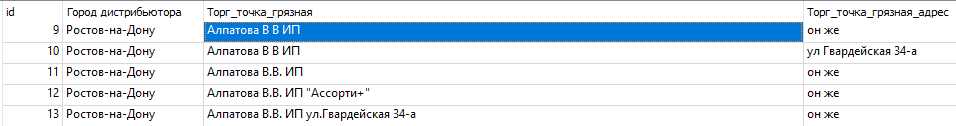
***
Так и среди адресов:
***
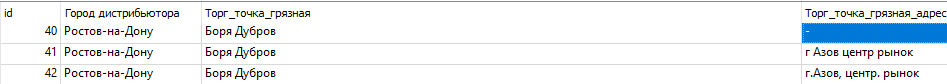
***
Также встречались ситуации, когда для одной торговой точки были указаны несколько адресов.
***
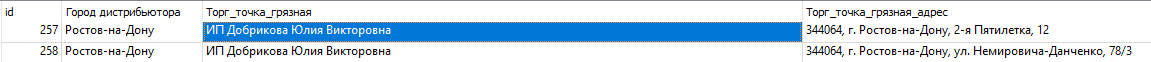
***
**Выполним проверку.** Сперва выведем количество уникальных названий торговых точек. Затем попробуем отфильтровать названия и выведем аналогичное количество ещё раз.

In [7]:
# Количество уникальных названий торговых точек.
df_outlets['Торг_точка_грязная'].nunique()

11074

In [8]:
# Количество уникальных названий торговых точек после обработки:
# - удаление пробелов;
# - удаление знаков препинания;
# - приведение символов к нижнему регистру.
(
df_outlets['Торг_точка_грязная']
    .str
    .replace(' ', '', regex=False)
    .str
    .replace('.', '', regex=False)
    .str
    .replace(',', '', regex=False)
    .str
    .replace('"', '', regex=False)
#     .str
#     .replace('<', '', regex=False)
#     .str
#     .replace('>', '', regex=False)
    .str
    .lower()
    .nunique()
)

10025

**Анализ результатов проверки** позволил установить, что неявные дубликаты могут быть частично устранены при помощи обработки.

После обработки число уникальных названий торговых точек снизилось, что позволило сопоставить неявные дубликаты.

Группировка по обработанным названиям позволит сформировать все варианты адресов для неявных дубликатов.

#### Шаг 2 - формирование хеш-названий торговых точек <a id='step_1_2'></a>

Одни и те же торговые точки имеют несколько адресов. Как было установлено в **Шаге 1**, обработка названий позволит идентифицировать точки с минимальными различиями в своих названиях.

Создадим новое поле "name_processed", которое будет содержать обработанные хеш-названия торговых точек.

In [9]:
# Формирование обработанных названий торговых точек для группировки неявных дубликатов.
df_outlets['name_processed'] = (
    df_outlets['Торг_точка_грязная']
    .str
    .replace(' ', '', regex=False)
    .str
    .replace('.', '', regex=False)
    .str
    .replace(',', '', regex=False)
    .str
    .replace('"', '', regex=False)
    .str
    .lower()
)

# Проверка.
df_outlets.head(10)

,id,Город дистрибьютора,Торг_точка_грязная,Торг_точка_грязная_адрес,outlet_clean_id,name_processed
0,1,Ростов-на-Дону,ИП Гаврилов С.А.,"п.Глубокий, ул.Артёма 44",None,ипгавриловса
1,2,Ростов-на-Дону,ИП Малышева,-,None,ипмалышева
2,3,Ростов-на-Дону,Абасян А.П. ИП,он же,None,абасянапип
3,4,Ростов-на-Дону,"Азатян Н,С. ИП ул. Ленина",он же,None,азатяннсипулленина
4,5,Ростов-на-Дону,Айдинов В.Я.,он же,None,айдиноввя
5,6,Ростов-на-Дону,Алексеева Л П ИП,Буденного 161,None,алексеевалпип
6,7,Ростов-на-Дону,Алексеева Л П ИП,он же,None,алексеевалпип
7,8,Ростов-на-Дону,ИП Алиева Т.М.,Ип Алиева Т.М. п.Газетный 39,None,ипалиеватм
8,9,Ростов-на-Дону,Алпатова В В ИП,он же,None,алпатоваввип
9,10,Ростов-на-Дону,Алпатова В В ИП,ул Гвардейская 34-а,None,алпатоваввип


#### Шаг 3 - формирования списка уникальных адресов для каждой торговой точки <a id='step_1_3'></a>

Теперь можно выполнить группировку по хеш-названию для получения списка уникальных адресов для каждой торговой точки.

Создадим новую таблицу "df_addresses" для данной реализации.

In [10]:
# Формирования списка адрессов для каждого обработанного дубликата.
df_addresses = (
    df_outlets
    .groupby(by='name_processed')['Торг_точка_грязная_адрес']
    .unique()
    .reset_index()
)

df_addresses.columns = ['name_processed', 'list_addresses']

# Проверка.
df_addresses.head(20)

,name_processed,list_addresses
0,24часаооо,[-]
1,7-ямаркетооо,"[-, пос Темерницкий ул Мира 2, пос. Темерницки..."
2,7днейооо,"[-, ул.Мадояна д.285/96]"
3,999ооомагазингастроном,[-]
4,999ооомагазинисток,"[-, 347880, Ростовская обл, Гуково г, Комсомол..."
5,<невыбран>,[-]
6,oooрустальволодарского,"[352900,Россия,Краснодарский кр, г Армавир,с/т..."
7,oooрустальгоголя,"[-, 352900 Россия Краснодарский кр г Армавир с..."
8,oooрустальзарявостока,"[352900,Россия,Краснодарский кр, г Армавир,с/т..."
9,oooрустальленина,"[-, 352900,Россия,Краснодарский кр, г Армавир,..."


#### Шаг 4 - фильтрация адресов <a id='step_1_4'></a>

Среди адресов присутствуют неинформативные значения "-" и "он же", данные значения должны быть отфильтрованы.

Реализуем фильтрацию.

In [11]:
# Обнаружено, но не добавлено:
# 'до 12часов'

# Значения для фильтрации.
list_addresses_to_filter = ['-', 'он же', '--------------------------------------', 'самовывоз', '0', '1', 'ба', 'б/а', 'Ж',
                           'БА', 'Б/А']

# Функция для фильтрации.
def func_filter(field, list_filter):
    
    # Сформировать новый список адресов без значений для фильтрации.
    field = [x for x in field if x not in list_filter]
    
    # Если после фильтрации список не пустой:
    if field != []:
        # вернуть новый отфильтрованный список.
        return field


# Вызов функции фильтрации для столбца "list_addresses".
df_addresses['list_addresses'] = (
    df_addresses['list_addresses'].apply(lambda x: func_filter(x, list_addresses_to_filter), 1)
)

# Проверка.
df_addresses.head(20)

,name_processed,list_addresses
0,24часаооо,None
1,7-ямаркетооо,"[пос Темерницкий ул Мира 2, пос. Темерницкий у..."
2,7днейооо,[ул.Мадояна д.285/96]
3,999ооомагазингастроном,None
4,999ооомагазинисток,"[347880, Ростовская обл, Гуково г, Комсомольск..."
5,<невыбран>,None
6,oooрустальволодарского,"[352900,Россия,Краснодарский кр, г Армавир,с/т..."
7,oooрустальгоголя,[352900 Россия Краснодарский кр г Армавир с/т ...
8,oooрустальзарявостока,"[352900,Россия,Краснодарский кр, г Армавир,с/т..."
9,oooрустальленина,"[352900,Россия,Краснодарский кр, г Армавир,с/т..."


#### Шаг 5 - сопоставление списка адресов <a id='step_1_5'></a>

Теперь для каждого обработанного названия торговой точки сформирован уникальный список адресов.

Реализуем соединение таблиц, чтобы получить список уникальных адресов для каждой торговой точки.

In [12]:
# Присоединение к таблице "df_outlets" таблицы "df_addresses" по столбцу "name_processed".
df_outlets = df_outlets.merge(right=df_addresses,
                              how='left',
                              left_on='name_processed',
                              right_on='name_processed')

# Удаление столбца "name_processed" - он больше не нужен.
df_outlets = df_outlets.drop(columns=['name_processed'])

# Проверка.
df_outlets.head(20)

,id,Город дистрибьютора,Торг_точка_грязная,Торг_точка_грязная_адрес,outlet_clean_id,list_addresses
0,1,Ростов-на-Дону,ИП Гаврилов С.А.,"п.Глубокий, ул.Артёма 44",None,"[п.Глубокий, ул.Артёма 44, п.Глубокий, ул.Артё..."
1,2,Ростов-на-Дону,ИП Малышева,-,None,None
2,3,Ростов-на-Дону,Абасян А.П. ИП,он же,None,"[346385, Ростовская обл, Красносулинский р-н, ..."
3,4,Ростов-на-Дону,"Азатян Н,С. ИП ул. Ленина",он же,None,"[346500, Ростовская обл, Шахты г, Ленина ул, д..."
4,5,Ростов-на-Дону,Айдинов В.Я.,он же,None,None
5,6,Ростов-на-Дону,Алексеева Л П ИП,Буденного 161,None,[Буденного 161]
6,7,Ростов-на-Дону,Алексеева Л П ИП,он же,None,[Буденного 161]
7,8,Ростов-на-Дону,ИП Алиева Т.М.,Ип Алиева Т.М. п.Газетный 39,None,[Ип Алиева Т.М. п.Газетный 39]
8,9,Ростов-на-Дону,Алпатова В В ИП,он же,None,"[ул Гвардейская 34-а, 346335, Ростовская обл, ..."
9,10,Ростов-на-Дону,Алпатова В В ИП,ул Гвардейская 34-а,None,"[ул Гвардейская 34-а, 346335, Ростовская обл, ..."


Для каждой торговой точки был сформирован список уникальный адресов.

В некоторых случаях в список могли попасть неинформативные значения, что связано с недостаточной фильтрацией.

В некоторых случаях в список могли попасть несколько адресов. Данная особенность обусловлена тем, что для одной точки могли быть указаны несколько адресов или один и тот же адрес, записанный иначе.

#### Шаг 6 - дедубликация <a id='step_1_6'></a>

Для записи сформированных списков уникальных адресов и сопоставления с торговыми точками напишем функцию "func_deduplication".

In [13]:
# Функция для записи списка уникальных адресов в таблицу "outlets_clean"
# и заполнения поля "outlet_clean_id" в таблице "outlets".
# 
# Функция принимает на вход строку таблицы "df_outlets",
# производит запись в базу для данной строки
# и возвращает новую строку с заполненным полем "outlet_clean_id".
# 
def func_deduplication(row):
    
    # Список уникальных адресов торговой точки.
    list_addresses = row['list_addresses']
    
    # Если для точки указаны адреса:
    if list_addresses is not None:
        
        # Выполнить преобразование для записи в базу.
        list_addresses = f'{list_addresses}'.replace("'", "`").replace('"', "'")
        
        # Подключиться к базе SQLite.
        sql_connection = sqlite3.connect(PATH_FILE_DB_SQLITE)
        
        # Сформировать SQL-запрос для получения соответствующего "id" из таблицы "outlets_clean"
        # для данного списка уникальных адресов торговой точки.
        sql_query = f'SELECT o.id ' \
                    f'FROM outlets_clean AS o ' \
                    f'WHERE o.`Торг_точка_чистый_адрес` = "{list_addresses}"'
        
        # Выполнить запрос и получить первую строку результирующей таблицы.
        sql_query_result = sql_connection.execute(sql_query).fetchone()
        
        # Если SQLite вернул соответствующую строку таблицы "outlets_clean":
        if sql_query_result is not None:
            # выбрать "id".
            id_address = sql_query_result[0]
        
        # Если SQLite вернул пустую таблицу, то такого списка адресов нет.
        else:
            # Сформировать DML-запрос для добавления отсутствующего списка адресов в таблицу "outlets_clean".
            dml_query = f'INSERT INTO `outlets_clean` (`Торг_точка_чистый_адрес`) ' \
                        f'VALUES ("{list_addresses}")'
            
            # Выполнить DML-запрос.
            sql_connection.execute(dml_query)
            sql_connection.commit()
            
            # Повторно запросить "id".
            id_address = sql_connection.execute(sql_query).fetchone()[0]
        
        # Сформировать DML-запрос для обновления таблицы "outlets":
        # для рассматриваемой записи указан соответствующий "outlet_clean_id" из таблицы "outlets_clean".
        dml_query = f'UPDATE `outlets` ' \
                    f'SET `outlet_clean_id` = {id_address} ' \
                    f'WHERE `id` = {row["id"]}'
        
        # Выполнить DML-запрос.
        sql_connection.execute(dml_query)
        sql_connection.commit()
        
        # Закрыть подключение к базе SQLite.
        sql_connection.close()
        
        # Заполнить поле "outlet_clean_id" для обрабатываемой строки.
        row['outlet_clean_id'] = id_address
    
    return row

In [14]:
%%time

# Применение функции.
df_outlets = df_outlets.apply(lambda row: func_deduplication(row), 1)

Wall time: 12min 16s


In [15]:
# Проверка.
df_outlets.head(20)

,id,Город дистрибьютора,Торг_точка_грязная,Торг_точка_грязная_адрес,outlet_clean_id,list_addresses
0,1,Ростов-на-Дону,ИП Гаврилов С.А.,"п.Глубокий, ул.Артёма 44",1.0,"[п.Глубокий, ул.Артёма 44, п.Глубокий, ул.Артё..."
1,2,Ростов-на-Дону,ИП Малышева,-,NaN,None
2,3,Ростов-на-Дону,Абасян А.П. ИП,он же,2.0,"[346385, Ростовская обл, Красносулинский р-н, ..."
3,4,Ростов-на-Дону,"Азатян Н,С. ИП ул. Ленина",он же,3.0,"[346500, Ростовская обл, Шахты г, Ленина ул, д..."
4,5,Ростов-на-Дону,Айдинов В.Я.,он же,NaN,None
5,6,Ростов-на-Дону,Алексеева Л П ИП,Буденного 161,4.0,[Буденного 161]
6,7,Ростов-на-Дону,Алексеева Л П ИП,он же,4.0,[Буденного 161]
7,8,Ростов-на-Дону,ИП Алиева Т.М.,Ип Алиева Т.М. п.Газетный 39,5.0,[Ип Алиева Т.М. п.Газетный 39]
8,9,Ростов-на-Дону,Алпатова В В ИП,он же,6.0,"[ул Гвардейская 34-а, 346335, Ростовская обл, ..."
9,10,Ростов-на-Дону,Алпатова В В ИП,ул Гвардейская 34-а,6.0,"[ул Гвардейская 34-а, 346335, Ростовская обл, ..."


Работа данного алгоритма может быть оптимизирована при помощи одновременной вставки всех списков уникальных адресов в таблицу "outlets_clean". Однако для этого таблица "outlets_clean" должна содержать ограничение на уникальность поля "Торг_точка_чистый_адрес".

## Реализация при помощи DML-запросов <a id='step_2'></a>

**Шаг 1 - реализация таблицы "outlets_clean"** <a id='step_2_1'></a>

Для реализации данного метода таблица "outlets_clean" должна иметь ограничение на уникальность поля "Торг_точка_чистый_адрес".

    CREATE TABLE outlets_clean (
        id                      INTEGER       NOT NULL
                                              PRIMARY KEY AUTOINCREMENT,
        Торг_точка_чистый_адрес VARCHAR (145) NOT NULL
                                              UNIQUE ON CONFLICT IGNORE
    );

**Шаг 2 - заполнение таблицы "outlets_clean"** <a id='step_2_2'></a>

Аналогичным образом формируется 

    -- CTE для обработки названий торговых точек и отсечения неинформативных адресов.
    WITH t1 AS (
        SELECT
            LOWER(REPLACE(REPLACE(REPLACE(REPLACE(o.`Торг_точка_грязная`, ' ', ''), '.', ''), ',', ''), '"', '')) AS name,
            o.`Торг_точка_грязная_адрес` AS address_dirty
        FROM
            outlets AS o
        WHERE
            o.`Торг_точка_грязная_адрес` <> '-'
            AND o.`Торг_точка_грязная_адрес` <> 'он же'
            AND o.`Торг_точка_грязная_адрес` <> '--------------------------------------'
            AND o.`Торг_точка_грязная_адрес` <> 'самовывоз'
            AND o.`Торг_точка_грязная_адрес` <> '0'
            AND o.`Торг_точка_грязная_адрес` <> '1'
            AND o.`Торг_точка_грязная_адрес` <> 'ба'
            AND o.`Торг_точка_грязная_адрес` <> 'б/а'
            AND o.`Торг_точка_грязная_адрес` <> 'Ж'
            AND o.`Торг_точка_грязная_адрес` <> 'БА'
            AND o.`Торг_точка_грязная_адрес` <> 'Б/А'
        )

    -- Вставка списков уникальных адресов.
    INSERT INTO outlets_clean (`Торг_точка_чистый_адрес`)
    SELECT
        GROUP_CONCAT(t1.address_dirty, '|') AS list_addresses
    FROM
        t1
    GROUP BY
        t1.name;

**Шаг 3 - обновление поля "outlet_clean_id" в таблице "outlets"** <a id='step_2_3'></a>

Далее в таблице "outlets" для каждой торговой точки при помощи оконной функции формируется список уникальных адресов. Затем в соответствии с сформированным списком адресов полю "outlet_clean_id" присваивается значение "id" из таблицы "outlets_clean".

    -- CTE для формирования хеш-имени и "чистого" адреса.
    WITH t1 AS (
        SELECT
            o.`Торг_точка_грязная` AS name, 
            LOWER(REPLACE(REPLACE(REPLACE(REPLACE(o.`Торг_точка_грязная`, ' ', ''), '.', ''), ',', ''), '"', '')) AS name_hash,
            REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(o.`Торг_точка_грязная_адрес`, '-', ''), 'он же', ''), '--------------------------------------', ''), 'самовывоз', ''), '0', ''), '1', ''), 'ба', ''), 'б/а', ''), 'Ж', ''), 'БА', ''), 'Б/А', '') AS address_clear
        FROM
            outlets AS o
        ),

    -- CTE: если после фильтрации адрес пустой (т.е. адрес содержал только мусор), то присвоить NULL.
    t2 AS (
        SELECT
            t1.name,
            t1.name_hash,
            IIF(t1.address_clear = '', NULL, t1.address_clear) AS address_clear
        FROM
            t1
        ),

    -- CTE для формирования списка адресов для каждой торговой точки.
    t3 AS (
        SELECT
            t2.name,
            --t2.name_hash,
            --t2.address_dirty,
            GROUP_CONCAT(t2.address_clear, '|') OVER(PARTITION BY t2.name_hash) AS list_addresses
        FROM
            t2
        )

    -- Вставка соответствующего outlet_clean_id для каждой торговой точки, где сформированный список адресов совпадает с списком адресов из таблицы "outlets_clean".
    UPDATE outlets
    SET outlet_clean_id = (SELECT oc.id FROM outlets_clean AS oc WHERE oc.`Торг_точка_чистый_адрес` = (SELECT t3.list_addresses FROM t3 WHERE t3.name = `Торг_точка_грязная`));

Выполнение при помощи DML-запросов заняло 38 минут.
***

***
Данный метод может быть оптимизирован при использовании дополнительного поля или таблицы для предварительно вычисленного списка уникальных адресов для каждой торговой точки. Оптимизация значительно сократит время выполнение последнего запроса, так как позволит избежать ресурсоёмкого вычисления списка уникальных адресов при каждой вставке.